# Rice Seed Classification

How will you classify the bellow two images?

![1rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/11.jpg) Proper Shaped Rice Seed

![2rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/141.jpg) Broken Rice Seed



In [ ]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
#creates a confusion matrix of the labelled dataset based on the regression line.
def plot_confusion_matrix(cm, classes,                          
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    #code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
!#we will use the rice seed image datset
!apt-get install subversion > /dev/null
!svn export https://github.com/totti0223/deep_learning_for_biologists_with_keras/trunk/notebooks/data/image image > /dev/null

In [ ]:
#this command below see inspects part of the files which have been downloaded from the cell above
!ls image
!ls image/train
!ls image/train/broken #prints 

test  test.txt	train  train.txt
broken	proper
141.jpg  177.jpg  213.jpg  248.jpg  274.jpg  300.jpg  326.jpg  352.jpg	378.jpg
142.jpg  178.jpg  214.jpg  249.jpg  275.jpg  301.jpg  327.jpg  353.jpg	379.jpg
144.jpg  179.jpg  215.jpg  250.jpg  276.jpg  302.jpg  328.jpg  354.jpg	380.jpg
145.jpg  180.jpg  216.jpg  251.jpg  277.jpg  303.jpg  329.jpg  355.jpg	381.jpg
147.jpg  182.jpg  217.jpg  252.jpg  278.jpg  304.jpg  330.jpg  356.jpg	382.jpg
150.jpg  184.jpg  218.jpg  253.jpg  279.jpg  305.jpg  331.jpg  357.jpg	383.jpg
152.jpg  185.jpg  219.jpg  254.jpg  280.jpg  306.jpg  332.jpg  358.jpg	384.jpg
155.jpg  186.jpg  220.jpg  255.jpg  281.jpg  307.jpg  333.jpg  359.jpg	385.jpg
156.jpg  189.jpg  221.jpg  256.jpg  282.jpg  308.jpg  334.jpg  360.jpg	386.jpg
158.jpg  191.jpg  222.jpg  257.jpg  283.jpg  309.jpg  335.jpg  361.jpg	387.jpg
160.jpg  194.jpg  223.jpg  258.jpg  284.jpg  310.jpg  336.jpg  362.jpg	388.jpg
161.jpg  195.jpg  224.jpg  259.jpg  285.jpg  311.jpg  337.jpg  363.jpg	389.jpg
162.jp

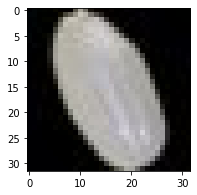

In [ ]:
#let's visualize a single file
image = imread("image/train/proper/100.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [ ]:
#load training dataset
X_train = []
y_train = []

for root, dirs, files in os.walk("image/train"): #load training dataset from the directory of the github repo
    files = [x for x in files if x.endswith(".jpg")] #appends all the image files
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.             
        image = resize(image,(28,28))              #resizing the image to shorter format for efficient storage.
        X_train.append(image)        
        category = os.path.split(root)[-1]          #takes the label of the training  dataset from the folder names ("proper and broken")
        if category == "proper":                    #assigns proper grain seeds a label of zero and broken one a label of 1
            y_train.append(0)
        else:
            y_train.append(1)
X_train = np.array(X_train)
y_train = np.array(y_train)



#load test dataset
X_test = []
y_test = []

for root, dirs, files in os.walk("image/test"):             #obtains test dataset similarly from the image/test folder
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(28,28))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_test.append(0)
        else:
            y_test.append(1)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("train dataset shape is:", X_train.shape,y_train.shape)
print("test dataset shape is:", X_test.shape,y_test.shape)

train dataset shape is: (377, 28, 28, 3) (377,)
test dataset shape is: (20, 28, 28, 3) (20,)


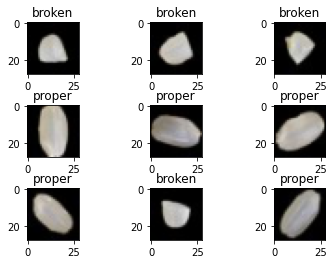

In [ ]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

index = np.random.randint(0,X_train.shape[0],size=9) #plotting random 9 images from the train dataset

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "proper"
    else:
        label = "broken"
    plt.title(label)
    plt.imshow(X_train[idx])

(28, 28, 3)


Text(0.5, 1.0, 'original')

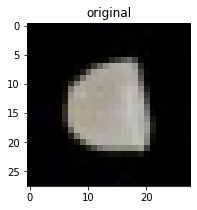

In [ ]:
#Let's try it for one image
image = X_train[120]

#the original image
print(image.shape)
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title("original")

(28, 28)


Text(0.5, 1.0, 'gray converted')

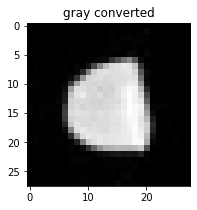

In [ ]:
#gray conversion
gray = rgb2gray(image)
print(gray.shape)
plt.figure(figsize=(3,3))
plt.imshow(gray, cmap=plt.cm.gray)
plt.title("gray converted")

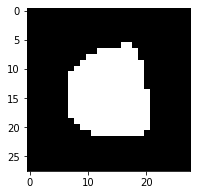

In [ ]:
#binary conversion
threshold = threshold_otsu(gray)
binary = gray > threshold
plt.figure(figsize=(3,3))
plt.imshow(binary, cmap=plt.cm.gray)

now that we have a nice binary image, we can isolate the region of rice seed which corresponds to the white region of the image above.

In [ ]:
label_im, nb_labels = ndimage.label(binary)
regionprops = measure.regionprops(label_im, intensity_image=gray) #using skimage library functions to find the major and minor axis and area of the rice grains
regionprop = regionprops[0]

print("area is",regionprop.area)
print("major axis length is", regionprop.major_axis_length)
print("minor axis length is", regionprop.minor_axis_length)

area is 184
major axis length is 16.30765979402375
minor axis length is 14.687263669042276


In [ ]:
#Some experimental code for fun. I plan to use Ratio of major and minor axis and area and plot the same stuff and see how it looks on the plot rather than just area as in the code
def quant_area_ratio(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area, regionprop.major_axis_length/regionprop.minor_axis_length


    #test
area, r  = quant_area_ratio(image)
print(r)


1.1103266177754358


In [ ]:
X_train_area = []
X_train_ratio = []
for image in X_train:
    area, r = quant_area_ratio(image)
    X_train_area.append(area)
    X_train_ratio.append(r)

X_test_area = []
X_test_ratio = []
for image in X_test:
    area, r = quant_area_ratio(image)
    X_test_area.append(area)
    X_test_ratio.append(r)


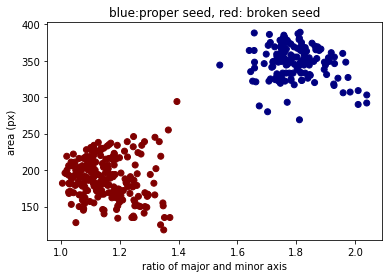

In [ ]:
#check the calculated data area value of training dataset
plt.scatter(X_train_ratio,X_train_area,c=y_train,cmap="jet")
plt.xlabel("ratio of major and minor axis")
plt.ylabel("area (px)")
plt.title("blue:proper seed, red: broken seed")

plt.show()

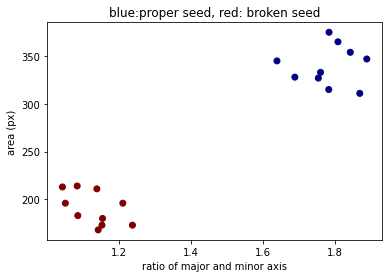

In [ ]:
plt.scatter(X_test_ratio,X_test_area,c=y_test,cmap="jet")
plt.xlabel("ratio of major and minor axis")
plt.ylabel("area (px)")
plt.title("blue:proper seed, red: broken seed")

plt.show()

In [ ]:
#bundling the above into a function
def quantify_area(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area

#test
area  = quantify_area(image)
print(area)

333


In [ ]:
X_train_area = []
for image in X_train:
    area = quantify_area(image)
    X_train_area.append(area)

X_test_area = []
for image in X_test:
    area = quantify_area(image)
    X_test_area.append(area)

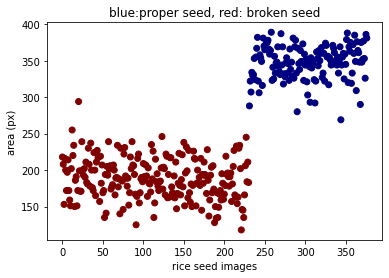

In [ ]:
#check the calculated data area value of training dataset
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.title("blue:proper seed, red: broken seed")

plt.show()

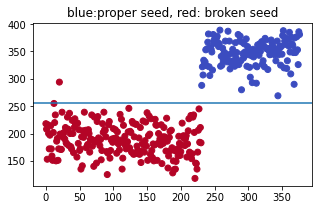

Confusion matrix, without normalization


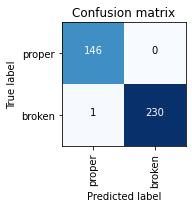

In [ ]:
#define an area threshold that can seperate the two classes
#must change from the default value or it won't seperate nicely.
#run this code once and try the suitable value that can seperate blue and red with the horizontal lines
area_threshold = 256


#classify whether the image is a proper seed or a broken seed according to the area_threshold value
train_y_pred = []
for area in X_train_area:
    if area > area_threshold:
        train_y_pred.append(0)
    else:
        train_y_pred.append(1)
        

#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
plt.title("blue:proper seed, red: broken seed")
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_train, train_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])

plt.show()

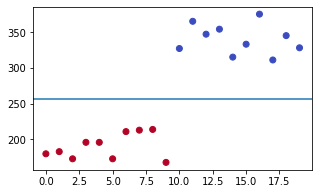

Confusion matrix, without normalization


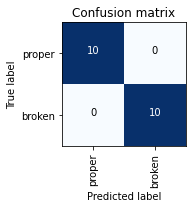

In [ ]:
#evaluate it with the test dataset
test_y_pred = []
for area in X_test_area:
    if area > area_threshold:
        test_y_pred.append(0)
    else:
        test_y_pred.append(1)
        
#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_test_area)),X_test_area,c=y_test,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_test, test_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])
plt.show()

correct label is:  0
predicted label is:  0


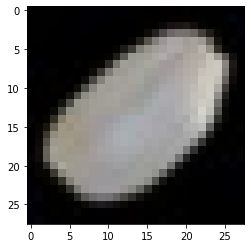

In [ ]:
#build a classifier

def manual_classifier(image,area_threshold):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    if area > area_threshold:
        return 0
    else:
        return 1

# get a image from test dataset #value must be lower than the size of the test dataset(20-1)
n = 15
image = X_test[n]
label = y_test[n]
area_threshold = 275 #modified the threshold value from 350 to 275 for a better classification accuracy
prediction = manual_classifier(image,area_threshold)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)